In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
from sklearn.preprocessing import LabelEncoder
import panel as pn

In [151]:
file = "../data/raw/houses_moreinfo.csv"
df = pd.read_csv(file)

In [152]:
# Must-have cleaning
df = df.drop('has_balcony', axis=1) # Remove 'has_balcony' column
df = df[df['price'].notna()] # Remove all properties where 'price' is NaN
df = df[df['life_annuity'] != 1] # Remove all properties with life annuity
df = df.drop('life_annuity', axis=1)
df = df.drop('id', axis=1)
df = df.drop('sale_type', axis=1)
df = df.drop('type_sale', axis=1)
df = df[~df['subtype'].isin(
    ['MIXED_USE_BUILDING', 'OTHER_PROPERTY',
     'MANSION', 'MANOR_HOUSE', 'CASTLE',
    'MIXED_USE_BUILDING', 'APARTMENT_BLOCK'])]

df = df[(df['area_total'] > 0) & (df['area_total'].notna())]
df = df[(df['living_area'].notna()) & (df['living_area'] > 0)]

# Optional cleaning
#df = df[df['heating'].notna()]
#df = df[df['epc'].notna()]
#df = df[df['state_construction'].notna()]
#df = df[df['bathrooms'].notna()]
#df = df[df['construction_year'].notna()]
#df = df[df['garden_area'].notna()]

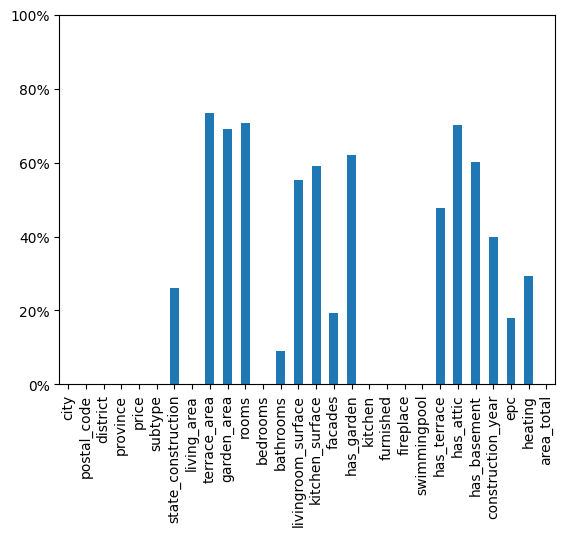

In [153]:
number_of_rows = df.shape[0]
number_of_nan_rows = df.isna().sum()
percentage_of_nan = (number_of_nan_rows / number_of_rows) * 100

percentage_of_nan.plot(kind='bar')
plt.ylim(0, 100)
ticks = np.arange(0, 101, step=20)

plt.yticks(ticks, [f"{tick}%" for tick in ticks])

plt.show()

In [154]:
print('Number of properties left after cleaning:', df.shape[0])

Number of properties left after cleaning: 30554


In [155]:
df.columns

Index(['city', 'postal_code', 'district', 'province', 'price', 'subtype',
       'state_construction', 'living_area', 'terrace_area', 'garden_area',
       'rooms', 'bedrooms', 'bathrooms', 'livingroom_surface',
       'kitchen_surface', 'facades', 'has_garden', 'kitchen', 'furnished',
       'fireplace', 'swimmingpool', 'has_terrace', 'has_attic', 'has_basement',
       'construction_year', 'epc', 'heating', 'area_total'],
      dtype='object')

In [156]:
fig = px.pie(df, names='subtype', title='Type of Real Estate in Belgium')
fig.show()

In [157]:
mean_price_per_province = df.groupby('province')['price'].median().sort_values(ascending=False)
number_of_properties_per_province = df['province'].value_counts().sort_index()

px.bar(df, x=mean_price_per_province.index, y=mean_price_per_province.values, color=number_of_properties_per_province.values, labels ={
    'x':'Province',
    'y':'Median Price of Properties (€)',
    'color':'Number of Properties Listed for Sale'
    })


In [158]:
mean_price_per_province = df.groupby('province')['price'].mean().sort_values(ascending=False)
number_of_properties_per_province = df['province'].value_counts().sort_index()

px.bar(df, x=mean_price_per_province.index, y=mean_price_per_province.values, color=number_of_properties_per_province.values, labels ={
    'x':'Province',
    'y':'Mean Price of Properties (€)',
    'color':'Number of Properties Listed for Sale'
    })


Brussels significantly more expansive and have more properties for sale

Waloon Brabant: expensive, few properties.
Hainaut: cheap, many properties.
 
Outliers:
1) Luxembourg, Namur, Liege: cheap, few properties.
2) West Flanders: expensive, many properties.

In [159]:
df['state_construction'] = df.state_construction.replace({
    'TO_RESTORE': "To Restore",
    "TO_RENOVATE": "To Restore",
    "TO_BE_DONE_UP": "To Restore",
    "JUST_RENOVATED":"Good",
    "GOOD":"Good",
    "AS_NEW":"Excellent"
    })

df_province_by_state_construction = df.groupby('province')['state_construction'].value_counts()
total_counts = df_province_by_state_construction.groupby(level=0).sum()
df_province_by_state_construction_percentage = df_province_by_state_construction / total_counts
df_percentage_reset = df_province_by_state_construction_percentage.reset_index(name='percentage')
df_pivoted = df_percentage_reset.pivot(index='province', columns='state_construction', values='percentage')

fig = go.Figure()

for column in df_pivoted.columns:
    fig.add_trace(go.Bar(x=df_pivoted.index, y=df_pivoted[column], name=column))

fig.update_layout(
    barmode='stack',
    title='Percentage of House Conditions by Province',
    xaxis_title='Province',
    yaxis_title='Percentage',
    yaxis_tickformat='.1%'
    )

fig.show()

In [160]:
# Create the histogram
fig1 = px.histogram(df, x="state_construction", histnorm='percent')
fig1.update_yaxes(range=[0, 100])

# Create the bar chart
mean_price_per_state_construction = df.groupby('state_construction')['price'].median()
fig2 = px.bar(x=mean_price_per_state_construction.index, y=mean_price_per_state_construction.values, labels={'x':'State of the construction', 'y':'mean price'})

# Create a figure with subplots
fig = go.Figure()

# Add the histogram to the figure
fig.add_trace(fig1.data[0])

# Add the bar chart to the figure
fig.add_trace(fig2.data[0])

# Hide the second trace (the bar chart) by default
fig.data[1].visible = False

# Create a dropdown menu
buttons = [
    dict(label="State of construction in %", method="update", args=[{"visible": [True, False]}]),
    dict(label="Mean Price of each state", method="update", args=[{"visible": [False, True]}])
]

# Add the dropdown menu to the figure
fig.update_layout(updatemenus=[dict(buttons=buttons)])

# Show the figure
fig.show()

In [161]:
df.head()

,city,postal_code,district,province,price,subtype,state_construction,living_area,terrace_area,garden_area,...,furnished,fireplace,swimmingpool,has_terrace,has_attic,has_basement,construction_year,epc,heating,area_total
0,Wenduine,8420,Oostend,West Flanders,163000.0,CHALET,Excellent,62.0,NaN,110.0,...,0,0,0,NaN,NaN,NaN,2023.0,NaN,GAS,155.0
1,Heist-aan-Zee,8301,Brugge,West Flanders,108000.0,BUNGALOW,Excellent,51.0,NaN,120.0,...,0,0,0,NaN,NaN,NaN,2023.0,NaN,GAS,170.0
8,Zonhoven,3520,Hasselt,Limburg,392422.0,HOUSE,NaN,206.0,NaN,NaN,...,0,0,0,NaN,NaN,NaN,2023.0,NaN,GAS,370.0
11,Bredene,8450,Oostend,West Flanders,245000.0,HOUSE,Excellent,76.0,NaN,110.0,...,0,0,0,NaN,NaN,NaN,2023.0,B,GAS,150.0
15,Geel,2440,Turnhout,Antwerp,335527.0,HOUSE,NaN,160.0,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,431.0


In [162]:
# add a chart that shows where furnished properties are
# add chart with % of furnished properties
# add chart to show difference between mean of properties with furniture and without
# price per m^2 for furnished and not furnished properties
df.furnished.value_counts()

furnished
0    30217
1      337
Name: count, dtype: int64